# EMA-NetLogo

The purpose of this notebook is to provide a proof of concept for connecting [EMAworkbench](https://github.com/quaquel/EMAworkbench) and [NetLogo](http://www.netlogoweb.org) models through [pyNetLogo](https://github.com/quaquel/pyNetLogo).

Here, we use the [Wolf Sheep Predation](http://ccl.northwestern.edu/netlogo/models/WolfSheepPredation) model that comes with NetLogo by default, and the EMAworkbench NetLogo [example file](https://github.com/quaquel/EMAworkbench/blob/master/ema_workbench/examples/netlogo_example.py).

![WolfSheepPredation](http://ccl.northwestern.edu/netlogo/models/models/Sample%20Models/Biology/Wolf%20Sheep%20Predation.png)

## Setup and Run the NetLogo Model in Python

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import pyNetLogo

netlogo = pyNetLogo.NetLogoLink(gui=True) # This has no effect on macOS

netlogo.load_model('./models/Wolf Sheep Predation.nlogo')
netlogo.command('setup')

In [2]:
counts = netlogo.repeat_report(['count wolves','count sheep'], 200, go='go')

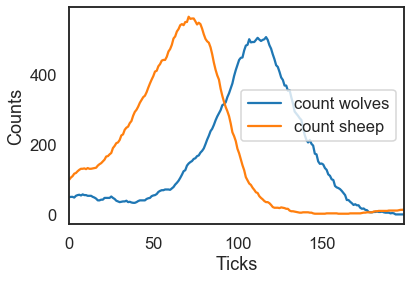

In [3]:
ax1 = counts.plot(use_index=True, legend=True)
ax1.set_xlabel('Ticks')
ax1.set_ylabel('Counts')
plt.show()

## Connect to EMAworkbench

In [4]:
from __future__ import unicode_literals, absolute_import

from ema_workbench.connectors.netlogo import NetLogoModel

from ema_workbench import (RealParameter, ema_logging,
                           TimeSeriesOutcome, SequentialEvaluator,
                           MultiprocessingEvaluator)

# Created on 20 mrt. 2013
#
# .. codeauthor::  jhkwakkel

# turn on logging
ema_logging.log_to_stderr(ema_logging.INFO)

model = NetLogoModel('predprey',
                        wd="models",
                        model_file="Wolf Sheep Predation.nlogo")
model.run_length = 100
model.replications = 10

model.uncertainties = [RealParameter("initial-number-sheep", 50, 100),
                        RealParameter("initial-number-wolves", 50, 100),
                        RealParameter("sheep-reproduce", 5, 10),
                        RealParameter("wolf-reproduce", 5, 10),
                        ]

model.levers = [RealParameter("grass-regrowth-time", 1, 99)]

model.outcomes = [TimeSeriesOutcome('sheep'),
                    TimeSeriesOutcome('wolves'),
                    TimeSeriesOutcome('grass')]

# perform experiments
n = 10

# with MultiprocessingEvaluator(model, n_processes=2,
                                # maxtasksperchild=4) as evaluator:
with SequentialEvaluator(model) as evaluator:
    run_results = evaluator.perform_experiments(scenarios=10, policies=10)

/usr/local/lib/python3.7/site-packages/ema_workbench/connectors/__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
[MainProcess/INFO] performing 10 scenarios * 10 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [5]:
from ema_workbench import (save_results, load_results)

save_results(run_results, 's10p10.tar.gz')
run_results = load_results('s10p10.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/jrwang/EMA-NetLogo/s10p10.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/jrwang/EMA-NetLogo/s10p10.tar.gz


In [ ]:
from ema_workbench.analysis import pairs_plotting
import matplotlib.pyplot as plt

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='policy',
                                         legend=False)
fig.set_size_inches(8,8)
plt.show()

In [ ]:
outcomes['wolves'].max()

In [ ]:
from ema_workbench.analysis import prim

x = experiments
y = outcomes['wolves'] > 3000 # some measure of sheep... like best survival
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()